# Pageview Analysis from Wikipedia for Oscar Winning Movies


## Data Acquisition

The data utilized in this analysis has been sourced from the Wikipedia API. The subsequent section outlines the process of establishing a connection with the API and storing the retrieved data in .json files. The primary objective here is to gather data pertaining to the Wikipedia pageviews for all Oscar-winning movies. The list of all Oscar-winning movies are stored at a local csv file named "thank_the_academy" The pageview endpoint contains valuable information such as view counts, access types, granularity levels, timestamps, and more.


In [1]:
import json
import time
import urllib.parse
import requests
import csv

# Acquiring data from the Wikimedia API, specifically the 'pageviews' endpoint

API_REQUEST_PAGEVIEWS_ENDPOINT = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/'

API_REQUEST_PER_ARTICLE_PARAMS = 'per-article/{project}/{access}/{agent}/{article}/{granularity}/{start}/{end}'

API_LATENCY_ASSUMED = 0.002      
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED

REQUEST_HEADERS = {
    'User-Agent': '<aprilgg@uw.edu>, University of Washington, MSDS DATA 512 - AUTUMN 2023',
}

# Creating a list with all Oscar-winning movies title from local csv file
ARTICLE_TITLES = []

TITLE_FILE = 'C:/Users/april/thank_the_academy.csv'

with open(TITLE_FILE, newline='', encoding='utf-8') as file:
    reader = csv.reader(file)
    for row in reader:
        if row:  
            ARTICLE_TITLES.append(row[0])

# Removing the header
ARTICLE_TITLES = ARTICLE_TITLES[1:]

# This template is used to map parameter values into the API_REQUST_PER_ARTICLE_PARAMS portion of an API request.
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE = {
    "project":     "en.wikipedia.org",
    "access":      "",    
    "agent":       "user",
    "article":     "",            
    "granularity": "monthly",
    "start":       "2015070100",   
    "end":         "2023090100"    
}



In [2]:
# Defining the function to request pageview for each article

def request_pageviews_per_article(article_title = None, 
                                  access_type = None,
                                  endpoint_url = API_REQUEST_PAGEVIEWS_ENDPOINT, 
                                  endpoint_params = API_REQUEST_PER_ARTICLE_PARAMS, 
                                  request_template = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE,
                                  headers = REQUEST_HEADERS):

    if article_title:
        request_template['article'] = article_title

    if not request_template['article']:
        raise Exception("Must supply an article title to make a pageviews request.")

    request_template['access'] = access_type
    
    article_title_encoded = urllib.parse.quote(request_template['article'].replace(' ','_'))
    request_template['article'] = article_title_encoded
    request_url = endpoint_url+endpoint_params.format(**request_template)
    
    try:
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response

In [3]:
# Defining the fucntions to save desired output to .json files
def save_json_data(filename, data):
    with open(filename, 'w') as file:
        json.dump(data, file)

def main():
    start_date = '20150701'
    end_date = '20230901'

    mobile_data = []
    desktop_data = []
    cumulative_data = []

    for title in ARTICLE_TITLES:
        mobile_app_response = request_pageviews_per_article(title, 'mobile-app')
        mobile_web_response = request_pageviews_per_article(title, 'mobile-web')
        desktop_response = request_pageviews_per_article(title, 'desktop')
        cumulative_response = request_pageviews_per_article(title, 'all-access') 
        
        if mobile_app_response:
            mobile_data.append(mobile_app_response)
            
        if mobile_web_response:
            mobile_data.append(mobile_web_response)
            
        if desktop_response:
            desktop_data.append(desktop_response)
        
        if cumulative_response:
            cumulative_data.append(cumulative_response)

    # Save monthly mobile access data
    mobile_filename = f'academy_monthly_mobile_{start_date}-{end_date}.json'
    save_json_data(mobile_filename, mobile_data)

    # Save monthly desktop access data
    desktop_filename = f'academy_monthly_desktop_{start_date}-{end_date}.json'
    save_json_data(desktop_filename, desktop_data)

    # Save monthly cumulative access data
    cumulative_filename = f'academy_monthly_cumulative_{start_date}-{end_date}.json'
    save_json_data(cumulative_filename, cumulative_data)    
    
if __name__ == "__main__":
    main()


## Data Analysis

In [1]:
import pandas as pd
import json
from pandas import json_normalize

In [2]:
# Read JSON files into DataFrames

with open('C:/Users/april/academy_monthly_mobile_20150701-20230901.json', 'r') as mobile_file:
     data = json.load(mobile_file)

mobile_df = pd.DataFrame(data[0]['items'])  

with open('C:/Users/april/academy_monthly_desktop_20150701-20230901.json', 'r') as desktop_file:
    data = json.load(desktop_file)

desktop_df = pd.DataFrame(data[0]['items'])  

combined_df = pd.merge(mobile_df, desktop_df, on=['article','timestamp'])
 

### Maximum Average and Minimum Average 
The first graph contain time series for the articles that have the highest average monthly page requests and the lowest average monthly page requests for desktop access and mobile access. This graph should have four lines (max desktop, min desktop, max mobile, min mobile).

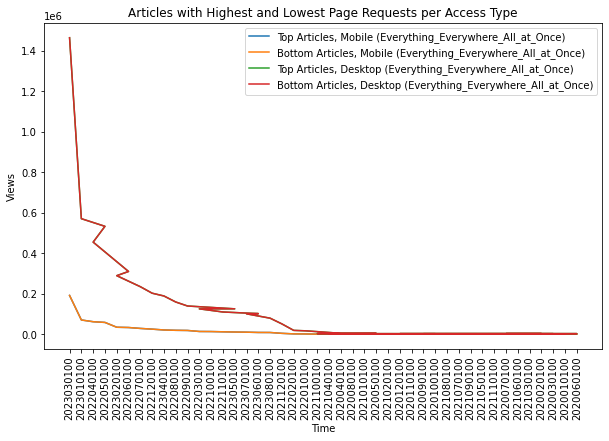

In [4]:
import matplotlib.pyplot as plt

# Sort articles by average monthly page requests for mobile and desktop
mobile_df = mobile_df.sort_values(by='views', ascending=False).reset_index()
desktop_df = desktop_df.sort_values(by='views', ascending=False).reset_index()

# Select the top and bottom articles for both mobile and desktop
top_mobile_article = mobile_df.iloc[0]
bottom_mobile_article = mobile_df.iloc[-1]
top_desktop_article = desktop_df.iloc[0]
bottom_desktop_article = desktop_df.iloc[-1]

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(mobile_df[mobile_df['article'] == top_mobile_article['article']]['timestamp'],
         mobile_df[mobile_df['article'] == top_mobile_article['article']]['views'],
         label=f'Top Articles, Mobile ({top_mobile_article["article"]})')
plt.plot(mobile_df[mobile_df['article'] == bottom_mobile_article['article']]['timestamp'],
         mobile_df[mobile_df['article'] == bottom_mobile_article['article']]['views'],
         label=f'Bottom Articles, Mobile ({bottom_mobile_article["article"]})')
plt.plot(desktop_df[desktop_df['article'] == top_desktop_article['article']]['timestamp'],
         desktop_df[desktop_df['article'] == top_desktop_article['article']]['views'],
         label=f'Top Articles, Desktop ({top_desktop_article["article"]})')
plt.plot(desktop_df[desktop_df['article'] == bottom_desktop_article['article']]['timestamp'],
         desktop_df[desktop_df['article'] == bottom_desktop_article['article']]['views'],
         label=f'Bottom Articles, Desktop ({bottom_desktop_article["article"]})')

plt.xlabel('Time')
plt.ylabel('Views')
plt.title('Articles with Highest and Lowest Page Requests per Access Type')
plt.xticks(rotation='vertical')

plt.legend()
plt.show()


I realized the data structure of the output json file is not what I was expected. 
As the result, when I read JSON to excel, it only read one film into the data frame.
Due to the time constraint, I will continue to perform my analysis based on the data availible in each dataframes

In [4]:
mobile_df.shape

(44, 8)

### Top 10 Peak Page Views -
The second graph contain time series for the top 10 article pages by largest (peak) page views over the entire time by access type. You first find the month for each article that contains the highest (peak) page views, and then order the articles by these peak values. The graph contain the top 10 for desktop and top 10 for mobile access (20 lines).


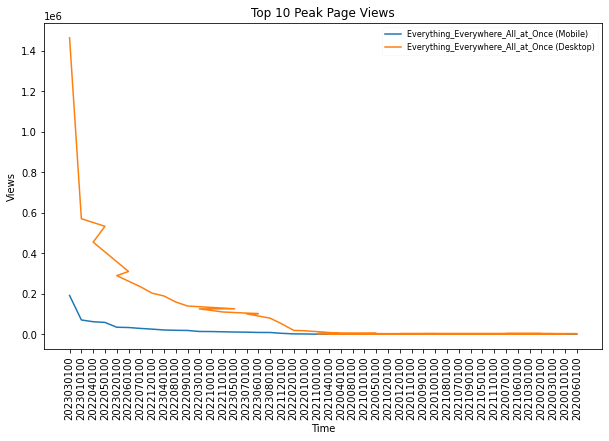

In [7]:
# Define a function to find the peak month and views for a given DataFrame
def find_peak_info(df):
    max_views_idx = df['views'].idxmax()
    peak_month = df.loc[max_views_idx, 'timestamp']
    peak_views = df.loc[max_views_idx, 'views']
    return peak_month, peak_views

# Getting top 10 articles for desktop
desktop_peak_info = []
for article in desktop_df['article'].unique():
    article_df = desktop_df[desktop_df['article'] == article]
    peak_month, peak_views = find_peak_info(article_df)
    desktop_peak_info.append({'article': article, 'peakMonth': peak_month, 'peakViews': peak_views})

top10_desktop = pd.DataFrame(desktop_peak_info).nlargest(10, 'peakViews')

# Getting top 10 articles for mobile
mobile_peak_info = []
for article in mobile_df['article'].unique():
    article_df = mobile_df[mobile_df['article'] == article]
    peak_month, peak_views = find_peak_info(article_df)
    mobile_peak_info.append({'article': article, 'peakMonth': peak_month, 'peakViews': peak_views})

top10_mobile = pd.DataFrame(mobile_peak_info).nlargest(10, 'peakViews')

# Plot
plt.figure(figsize=(10, 6))
plt.xticks(rotation='vertical')
plt.title('Top 10 Peak Page Views')

for article in top10_mobile['article']:
    article_data = mobile_df[mobile_df['article'] == article]
    plt.plot(article_data['timestamp'], article_data['views'], label=f'{article} (Mobile)')

for article in top10_desktop['article']:
    article_data = desktop_df[desktop_df['article'] == article]
    plt.plot(article_data['timestamp'], article_data['views'], label=f'{article} (Desktop)')

plt.legend(framealpha=0.1, prop={'size': 8})
plt.xlabel("Time")
plt.ylabel("Views")
plt.show()


### Fewest Months of Data 
The third graph should show pages that have the fewest months of available data. These will all be relatively short time series and should contain a set of the most recent academy award winners. The graph shows the 10 articles with the fewest months of data for desktop access and the 10 articles with the fewest months of data for mobile access.


In [ ]:
fewest_month_mobile = df_mobile.groupby(by=['article']).count().sort_values(by=['views'], ascending=True)[:10]
fewest_month_desktop = df_desktop.groupby(by=['article']).count().sort_values(by=['views'], ascending=True)[:10]

plt.figure(figsize=(10,6))
plt.xticks(rotation='vertical')
plt.title('Fewest Months of Data')
for article in fewest_month_mobile.index.tolist():
    plt.plot(mobile_df[mobile_df['article']==article]['timestamp'],
             mobile_df[mobile_df['article']==article]['views'],
             label=article+' Mobile')
for article in fewest_month_desktop.index.tolist():
    plt.plot(desktop_df[desktop_df['article']==article]['timestamp'],
             desktop_df[desktop_df['article']==article]['views'],
             label=article+' Desktop')
plt.legend(framealpha=0.1, prop={'size': 8})
plt.xlabel("Time)")
plt.ylabel("Views")

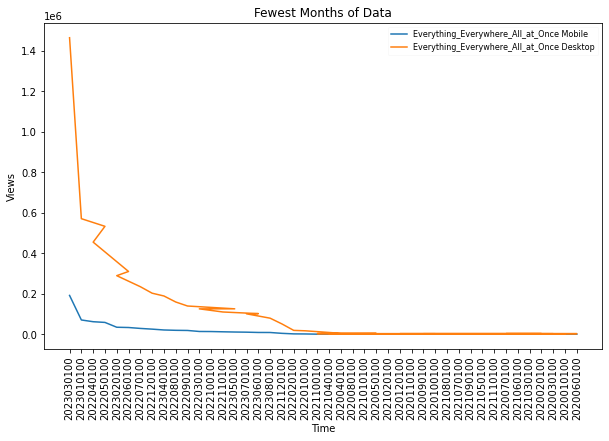

In [8]:
# Find the articles with the fewest months of data for mobile and desktop
fewest_month_mobile = mobile_df['article'].value_counts().nsmallest(10)
fewest_month_desktop = desktop_df['article'].value_counts().nsmallest(10)

# Plot
plt.figure(figsize=(10, 6))
plt.xticks(rotation='vertical')
plt.title('Fewest Months of Data')

# Iterate through the articles with the fewest months of data for mobile and desktop
for article in fewest_month_mobile.index:
    mobile_data = mobile_df[mobile_df['article'] == article]
    plt.plot(mobile_data['timestamp'], mobile_data['views'], label=f'{article} Mobile')

for article in fewest_month_desktop.index:
    desktop_data = desktop_df[desktop_df['article'] == article]
    plt.plot(desktop_data['timestamp'], desktop_data['views'], label=f'{article} Desktop')

plt.legend(framealpha=0.1, prop={'size': 8})
plt.xlabel("Time")
plt.ylabel("Views")
plt.show()
